In [1]:
# Transfer learning menggunakan MobileNetV3 Large
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Path dataset
trainPath = "D:/dataset_bungaCrop/train"
validPath = "D:/dataset_bungaCrop/val"

# Data augmentation dan preprocessing
trainGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # <--- Sesuai standar MobileNetV3
    rotation_range=30,                         # ditingkatkan
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.5, 1.5),
    fill_mode='nearest'
).flow_from_directory(trainPath, target_size=(320, 320), batch_size=32, class_mode='categorical')

validGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(validPath, target_size=(320, 320), batch_size=32, class_mode='categorical', shuffle=False)

Found 278 images belonging to 29 classes.
Found 74 images belonging to 29 classes.


In [3]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Jumlah kelas sesuai folder train
num_classes = 29  # Ubah ke 29 jika memang hanya 29 kelas

# Layer input eksplisit
input_tensor = Input(shape=(320, 320, 3))

# Base model dari MobileNetV3
baseModel = MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Head model
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Model final
model = Model(inputs=input_tensor, outputs=predictions)

# Freeze sebagian besar layer
for layer in baseModel.layers:
    layer.trainable = False  # Fine-tune nanti di tahap 2 training

# Compile model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Summary
model.summary()

# plot_model(model, show_shapes=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 320, 320,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 160, 160,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 160, 160,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 160, 160,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 160, 160,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 160, 160,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 160, 160,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 161, 161,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        256 │ expanded_conv_1_

 Total params: 3,280,541 (12.51 MB)

 Trainable params: 283,421 (1.08 MB)

 Non-trainable params: 2,997,120 (11.43 MB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint_cb = ModelCheckpoint(
    "best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
)

# Callback untuk menghentikan training jika tidak ada peningkatan
earlystop_cb = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
)

# Callback untuk menurunkan learning rate jika val_loss stagnan
lr_reduce_cb = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Latih model
history = model.fit(
    trainGenerator,
    validation_data=validGenerator,
    epochs=100,
    callbacks=[checkpoint_cb, lr_reduce_cb]
)


c:\Users\ASUS\Documents\Python\BRIN\MobileNetV3\envi_V3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0360 - loss: 4.2825
Epoch 1: val_accuracy improved from -inf to 0.05405, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.0371 - loss: 4.2777 - val_accuracy: 0.0541 - val_loss: 3.7943 - learning_rate: 1.0000e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0375 - loss: 4.1693
Epoch 2: val_accuracy did not improve from 0.05405
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0399 - loss: 4.1627 - val_accuracy: 0.0541 - val_loss: 3.6771 - learning_rate: 1.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0654 - loss: 4.0972
Epoch 3: val_accuracy improved from 0.05405 to 0.06757, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0653 - loss: 4.0919 - val_accuracy: 0.0676 - val_loss: 3.5584 - learning_rate: 1.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1051 - loss: 3.8253
Epoch 4: val_accuracy i

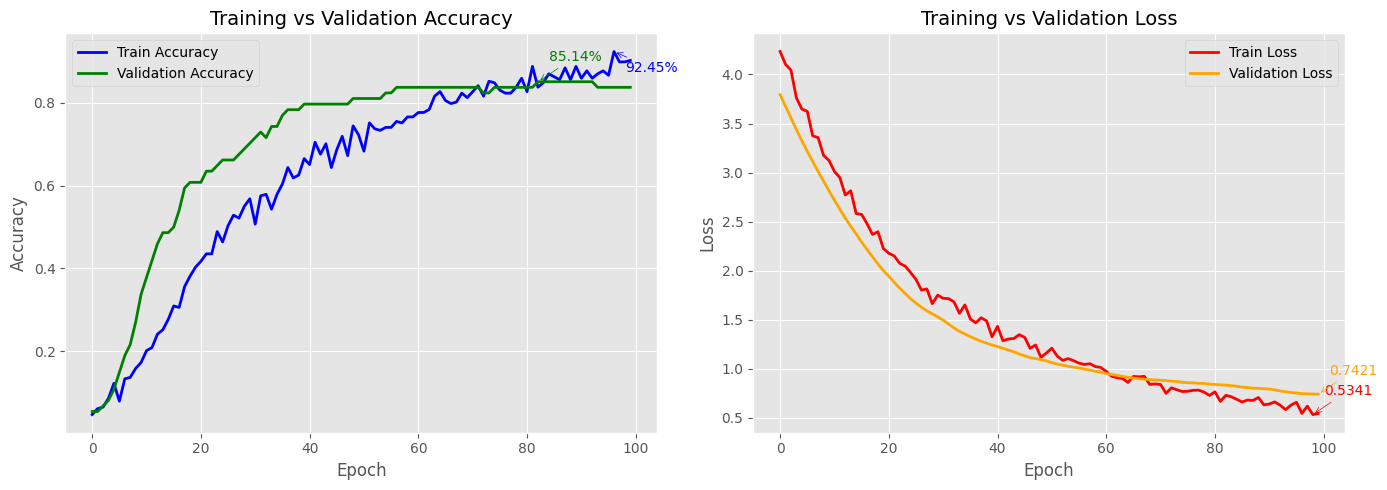

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure(figsize=(14, 5))
 
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Cari nilai maksimum dan epoch-nya
max_train_acc = max(train_acc)
epoch_max_train = train_acc.index(max_train_acc)

max_val_acc = max(val_acc)
epoch_max_val = val_acc.index(max_val_acc)

# Cari loss terendah (optional)
min_train_loss = min(train_loss)
epoch_min_train_loss = train_loss.index(min_train_loss)

min_val_loss = min(val_loss)
epoch_min_val_loss = val_loss.index(min_val_loss)

# --- Plot Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend()

# Anotasi train accuracy tertinggi
plt.annotate(f"{max_train_acc*100:.2f}%", 
             xy=(epoch_max_train, max_train_acc), 
             xytext=(epoch_max_train+2, max_train_acc-0.05),
             arrowprops=dict(arrowstyle="->", color='blue'),
             color='blue', fontsize=10)

# Anotasi val accuracy tertinggi
plt.annotate(f"{max_val_acc*100:.2f}%", 
             xy=(epoch_max_val, max_val_acc), 
             xytext=(epoch_max_val+2, max_val_acc+0.05),
             arrowprops=dict(arrowstyle="->", color='green'),
             color='green', fontsize=10)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', color='red', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()

# Anotasi loss terendah (optional)
plt.annotate(f"{min_train_loss:.4f}", 
             xy=(epoch_min_train_loss, min_train_loss), 
             xytext=(epoch_min_train_loss+2, min_train_loss+0.2),
             arrowprops=dict(arrowstyle="->", color='red'),
             color='red', fontsize=10)

plt.annotate(f"{min_val_loss:.4f}", 
             xy=(epoch_min_val_loss, min_val_loss), 
             xytext=(epoch_min_val_loss+2, min_val_loss+0.2),
             arrowprops=dict(arrowstyle="->", color='orange'),
             color='orange', fontsize=10)

plt.tight_layout()
plt.show()


In [14]:
# Evaluasi model di data validasi
loss, acc = model.evaluate(validGenerator, verbose=1)

# Ambil akurasi terbaik selama training
train_acc_max = max(history.history['accuracy'])
val_acc_max = max(history.history['val_accuracy'])

# Cetak hasil
print("\n📊 Evaluasi Model")
print("=" * 40)
print(f"🔹 Akurasi Train Tertinggi  : {train_acc_max * 100:.2f}%")
print(f"🔹 Akurasi Valid Tertinggi  : {val_acc_max * 100:.2f}%")
print(f"🔹 Akurasi Valid Terakhir   : {acc * 100:.2f}%")
print(f"🔹 Loss Valid Terakhir      : {loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8252 - loss: 0.7799

📊 Evaluasi Model
🔹 Akurasi Train Tertinggi  : 92.45%
🔹 Akurasi Valid Tertinggi  : 85.14%
🔹 Akurasi Valid Terakhir   : 83.78%
🔹 Loss Valid Terakhir      : 0.7421


In [15]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Path folder test
test_root = "D:/dataset_bungaCrop/test"

# Ambil label kelas dari train generator (pastikan 'trainGenerator' sudah tersedia sebelumnya)
class_labels = list(trainGenerator.class_indices.keys())

# Untuk menyimpan hasil prediksi
predictions = []

print("📦 Memulai prediksi gambar di folder test...\n")

# Loop setiap folder kelas
for class_dir in sorted(os.listdir(test_root)):
    class_path = os.path.join(test_root, class_dir)
    if not os.path.isdir(class_path):
        continue

    # Loop setiap gambar dalam folder kelas
    for fname in sorted(os.listdir(class_path)):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, fname)

        # Preprocessing gambar (mengikuti preprocessing MobileNetV3)
        img = image.load_img(img_path, target_size=(320, 320))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)  # <- penting: pakai ini sesuai training

        # Prediksi gambar
        pred = model.predict(img_array, verbose=0)
        predicted_class = np.argmax(pred)
        confidence = np.max(pred)

        # Simpan hasil
        true_label = class_dir
        predicted_label = class_labels[predicted_class]
        predictions.append((fname, true_label, predicted_label, confidence))

        # Tampilkan hasil prediksi
        print(f"📷 {fname}")
        print(f"   ✅ Ground Truth : {true_label}")
        print(f"   🧠 Prediksi     : {predicted_label} ({confidence * 100:.2f}%)\n")

# Hitung akurasi prediksi di folder test
correct = sum(1 for p in predictions if p[1] == p[2])
total = len(predictions)

if total > 0:
    accuracy = 100 * correct / total
    print(f"\n✅ Akurasi di folder test: {correct}/{total} = {accuracy:.2f}%")
else:
    print("⚠️ Tidak ada gambar yang diproses di folder test.")



📦 Memulai prediksi gambar di folder test...

📷 1.jpg
   ✅ Ground Truth : Affinis
   🧠 Prediksi     : Affinis (97.50%)

📷 14.jpg
   ✅ Ground Truth : Affinis
   🧠 Prediksi     : Affinis (80.11%)

📷 5.JPG
   ✅ Ground Truth : Affinis
   🧠 Prediksi     : Affinis (99.27%)

📷 15.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (98.52%)

📷 2.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (98.36%)

📷 3.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (98.63%)

📷 15.jpg
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (83.65%)

📷 18.jpg
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (97.53%)

📷 5.jpg
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (95.34%)

📷 10.jpg
   ✅ Ground Truth : Callistophylla
   🧠 Prediksi     : aff ranavensis (21.98%)

📷 4.JPG
   ✅ Ground Truth : Callistophylla
   🧠 Prediksi     : Callistophylla (99.04%)

📷 3.JPG
   ✅ Ground Truth : Clemensiorum
   🧠 Prediksi     : Clemensiorum (90.

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


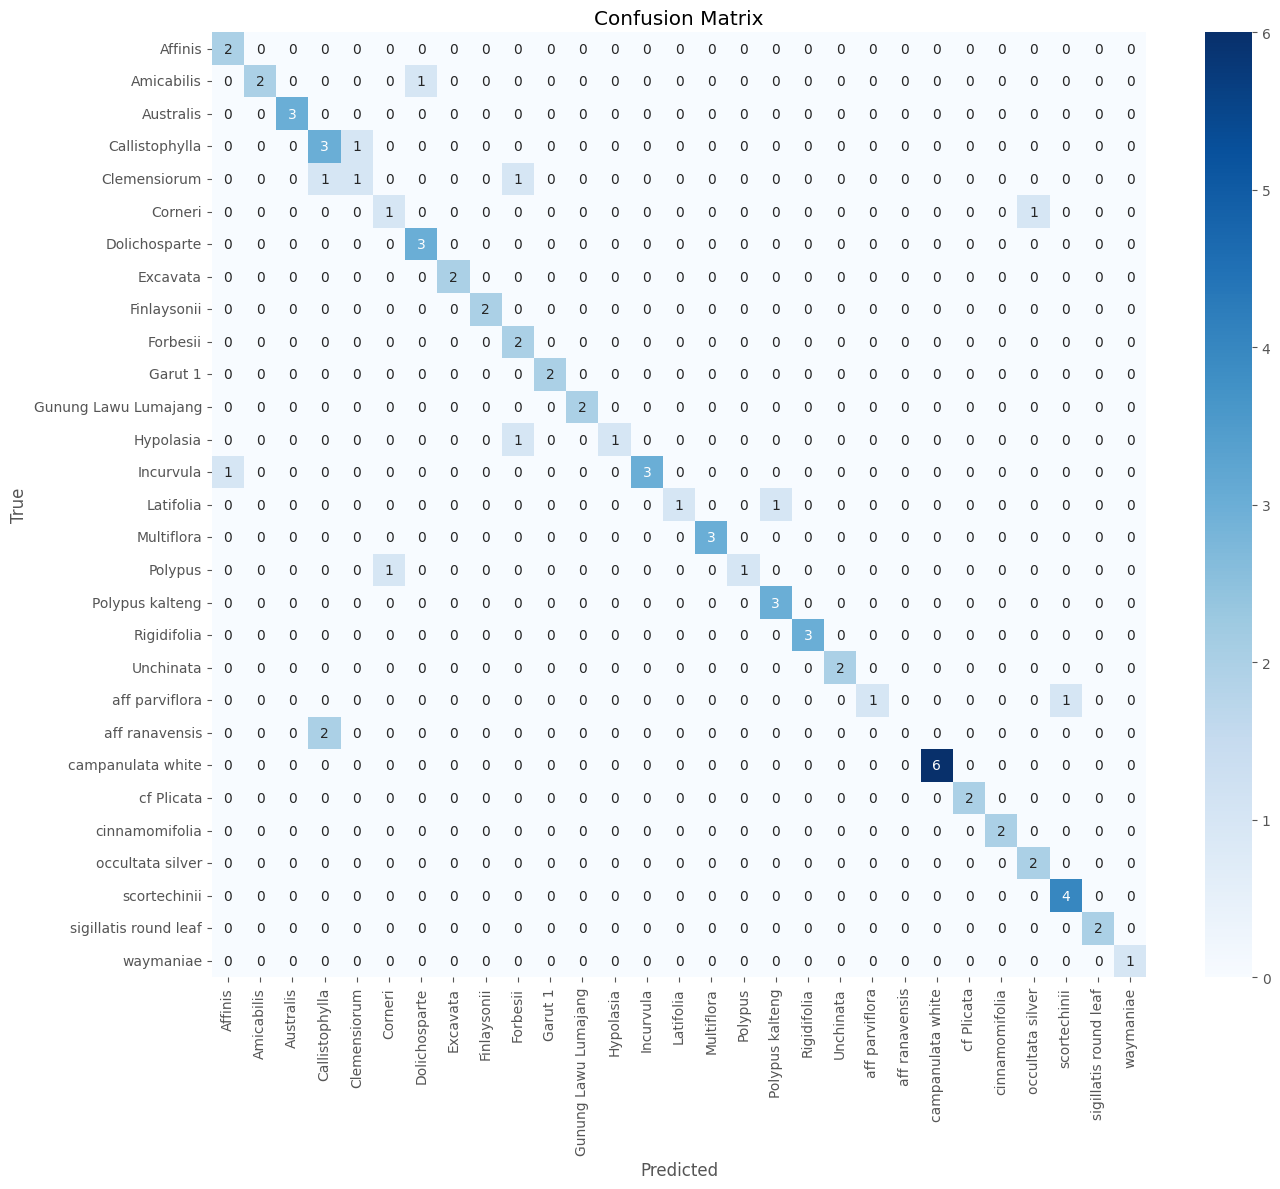

📋 Classification Report:
                       precision    recall  f1-score   support

              Affinis       0.67      1.00      0.80         2
           Amicabilis       1.00      0.67      0.80         3
            Australis       1.00      1.00      1.00         3
       Callistophylla       0.50      0.75      0.60         4
         Clemensiorum       0.50      0.33      0.40         3
              Corneri       0.50      0.50      0.50         2
        Dolichosparte       0.75      1.00      0.86         3
             Excavata       1.00      1.00      1.00         2
          Finlaysonii       1.00      1.00      1.00         2
             Forbesii       0.50      1.00      0.67         2
              Garut 1       1.00      1.00      1.00         2
 Gunung Lawu Lumajang       1.00      1.00      1.00         2
            Hypolasia       1.00      0.50      0.67         2
            Incurvula       1.00      0.75      0.86         4
            Latifolia       1

c:\Users\ASUS\Documents\Python\BRIN\MobileNetV3\envi_V3\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\Documents\Python\BRIN\MobileNetV3\envi_V3\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\Documents\Python\BRIN\MobileNetV3\envi_V3\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi semua batch validasi
Y_pred = model.predict(validGenerator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validGenerator.classes
labels = list(validGenerator.class_indices.keys())

# Validasi jumlah label
if len(np.unique(y_true)) != len(labels):
    print(f"⚠️ Jumlah kelas y_true = {len(np.unique(y_true))}, tapi jumlah label di generator = {len(labels)}")
    print("Pastikan semua kelas ada minimal 1 gambar di folder validasi.")
else:
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))


In [17]:
import tensorflow as tf

# Konversi langsung dari model terlatih di memori
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("model/mobilenetv3_bunga.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model langsung disimpan sebagai TFLite: mobilenetv3_bunga.tflite")


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpz5vcdmjc\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpz5vcdmjc\assets


Saved artifact at 'C:\Users\ASUS\AppData\Local\Temp\tmpz5vcdmjc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='keras_tensor_212')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  2757485750656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2757556498000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2757556495536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2757556499232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2757556496944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2757485749072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2755243665616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2755243662096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2755243663856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2755243664384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

# Untuk cek folder test

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# === Path ke model TFLite ===
tflite_model_path = "C:/Users/ASUS/Documents/Python/BRIN/model/7_Juli_09.50/mobilenetv3_daun.tflite"  # Ubah ke model bunga jika perlu

# === Load interpreter TFLite ===
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"✅ Model TFLite dimuat: {tflite_model_path}\n")

# === Path folder test ===
test_root = "D:/dataset_daun/test"

# Ambil label kelas dari trainGenerator
class_labels = list(trainGenerator.class_indices.keys())

predictions = []

print("📦 Mulai prediksi gambar di folder test...\n")

# Loop folder kelas
for class_dir in sorted(os.listdir(test_root)):
    class_path = os.path.join(test_root, class_dir)
    if not os.path.isdir(class_path):
        continue

    for fname in sorted(os.listdir(class_path)):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, fname)

        # Preprocessing gambar
        img = image.load_img(img_path, target_size=(320, 320))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array.astype(np.float32))  # Sesuaikan dtype

        # Inferensi TFLite
        interpreter.set_tensor(input_details[0]['index'], img_array)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_details[0]['index'])

        predicted_class = np.argmax(pred)
        confidence = np.max(pred)

        true_label = class_dir
        predicted_label = class_labels[predicted_class]
        predictions.append((fname, true_label, predicted_label, confidence))

        print(f"📷 {fname}")
        print(f"   ✅ Ground Truth : {true_label}")
        print(f"   🧠 Prediksi     : {predicted_label} ({confidence * 100:.2f}%)\n")

# === Hitung Akurasi Test ===
correct = sum(1 for p in predictions if p[1] == p[2])
total = len(predictions)

if total > 0:
    accuracy = 100 * correct / total
    print(f"\n✅ Akurasi di folder test: {correct}/{total} = {accuracy:.2f}%")
else:
    print("⚠️ Tidak ada gambar yang diproses di folder test.")


✅ Model TFLite dimuat: C:/Users/ASUS/Documents/Python/BRIN/model/7_Juli_09.50/mobilenetv3_daun.tflite

📦 Mulai prediksi gambar di folder test...

📷 1.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (43.29%)

📷 12.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (35.12%)

📷 8.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (50.48%)

📷 1.JPG
   ✅ Ground Truth : Anulata
   🧠 Prediksi     : Anulata (28.79%)

📷 12.JPG
   ✅ Ground Truth : Anulata
   🧠 Prediksi     : Anulata (26.09%)

📷 9.JPG
   ✅ Ground Truth : Anulata
   🧠 Prediksi     : Anulata (59.79%)

📷 1.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (46.28%)

📷 12.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Vitellina (46.36%)

📷 28.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Polypus (23.99%)

📷 4.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (74.90%)

📷 1.JPG
   ✅ Ground Truth : Callistophylla
   🧠 Prediksi     : Callistophylla 